# WIREFIRE Analysis on IRWIN/NGFS Validation

Purpose: Match IRWIN and NGFS alerts by location and time from January 2023 to July 2024.

By: Elsie Wang

Date: 08/11/2024

In [79]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import re
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
from geopy.distance import geodesic
import pandas as pd
import folium
from folium.plugins import HeatMap
from ipyleaflet import Map, Heatmap, LayerGroup, basemaps
import ipywidgets as widgets
from IPython.display import Image, display, clear_output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read and Write Files

In [80]:
def merge_csv_files(folder_path, output_file):
    """
    Merges all CSV files in month into a single month CSV file.

    Parameters:
    folder_path (str): The path to the folder containing the CSV files.
    output_file (str): The path where the combined CSV file will be saved.

    Returns:
    None
    """
    # List all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    # Loop through the list of CSV files and append each to the combined DataFrame
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file, index=False)

In [81]:
def dms_to_decimal(dms_str, hemisphere):
    """
    Converts a DMS (Degrees, Minutes, Seconds) formatted string into decimal degrees.

    Parameters:
    - dms_str (str): The DMS formatted string (e.g., "35° 38.676'").
    - hemisphere (str): The hemisphere identifier ('N', 'S', 'E', 'W').

    Returns:
    - float: The decimal degree equivalent of the DMS string.
    """
    match = re.match(r'(\d+)°\s(\d+\.\d+)\'', dms_str.strip())
    if match:
        degrees, minutes = map(float, match.groups())
        decimal = degrees + minutes / 60
        if hemisphere in ['S', 'W']:
            decimal = -decimal
        return decimal
    return None

def process_lat_lon(lat_lon):
    """
    Processes a latitude/longitude string in either DMS or decimal format and converts it 
    into separate latitude and longitude values.

    Parameters:
    - lat_lon (str): The latitude/longitude string, either in DMS format 
                     (e.g., "N 35° 38.676' W 119° 57.851'") or decimal format 
                     (e.g., "34.2662449244796, -117.460262071904").

    Returns:
    - tuple: A tuple containing the latitude and longitude as floats (lat, lon).
    """
    if isinstance(lat_lon, str) and re.match(r'[NSEW]\s\d+°\s\d+\.\d+\'', lat_lon.strip()):
        # Split the DMS lat/lon into latitude and longitude parts
        lat_str = re.search(r'N\s\d+°\s\d+\.\d+\'', lat_lon)
        lon_str = re.search(r'W\s\d+°\s\d+\.\d+\'', lat_lon)
        
        if lat_str and lon_str:
            lat = dms_to_decimal(lat_str.group().replace('N ', ''), 'N')
            lon = dms_to_decimal(lon_str.group().replace('W ', ''), 'W')
            return lat, lon
    elif isinstance(lat_lon, str):
        try:
            lat, lon = map(float, lat_lon.split(','))
            return lat, lon
        except ValueError:
            return None, None
    return None, None

# Define the input and output folders
input_folder = 'data/pre_merged_data/'
output_folder = 'data/merged_data/'

dataframes = []

# List all directories in the input folder
all_folders = os.listdir(input_folder)

# Filter out unwanted files and directories
valid_folders = [folder for folder in all_folders if os.path.isdir(os.path.join(input_folder, folder)) and folder not in ['.DS_Store', '.ipynb_checkpoints']]

# Iterate over each valid month folder
for folder in valid_folders:
    folder_path = os.path.join(input_folder, folder)
    
    # Iterate over each CSV file in the current folder
    for csv_file in os.listdir(folder_path):
        if csv_file.endswith('.csv'):
            file_path = os.path.join(folder_path, csv_file)
            
            # Load the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Process lat/lon column
            df[['lat', 'lon']] = df['lat/lon'].apply(lambda x: pd.Series(process_lat_lon(x)))
            
            # Add columns with the folder name and file name
            df['source_folder'] = folder
            df['source_file'] = csv_file
            
            # Append DataFrame to the list
            dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

In [82]:
# CA county shapefile
counties = gpd.read_file('data/ca_counties/CA_Counties.shp')
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.940 4059436.934, -13..."


## Data Cleaning

In [83]:
# Get rid of extra 'Unnamed' columns
combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('Unnamed')]
combined_df.head()

,id,type,timestamp,message,agency,DPA,county,OES region,lat/lon,pushed/reason,modeler,"notes (fire name, other)",lat,lon,source_folder,source_file
0,NaN,PP,2023-09-04 13:42,"Avenue A & 60th St W, Rosamond, CA, 93560, USA",KC,LOCAL,Kern,5,N 34° 49.208' W 118° 14.262',Nothing on cameras,Rawaf,NaN,34.820133,-118.237700,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv
1,NaN,PP,2023-09-04 14:13,"California Ave & Marella Way, Bakersfield, CA,...",KC,LOCAL,Kern,5,N 35° 21.836' W 119° 3.426',Urban,Rawaf,NaN,35.363933,-119.057100,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv
2,NaN,PP,2023-09-04 16:37,"Newquist Dr, Eglin Ct and Autumn Ridge Dr, Sha...",KC,LOCAL,Kern,5,N 35° 23.364' W 118° 55.337',Other - Enter reason,Treva,"Smoke, no additional resources",35.389400,-118.922283,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv
3,NaN,PP,2023-09-07 7:16,"Santa Rosa Ave & Bellevue Ave, Santa Rosa, CA,...",SOCO,LOCAL,Sonoma,2,N 38° 24.112' W 122° 42.811',Prescribed fire,Rawaf,NaN,38.401867,-122.713517,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv
4,1590963720.0,PP,2023-09-09 11:20,"Flying J Travel Plaza, 17047 Zachary Ave, Bake...",KC,LOCAL,Kern,5,N 35° 31.833' W 119° 11.260',Agriculture / farm,Jess,NaN,35.530550,-119.187667,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv


In [84]:
# Get number of alert types
print('Old value counts for alert type:')
print(combined_df['type'].value_counts())

# Mapping dictionary for cleaning the 'type' column
type_mapping = {
    'PP': 'PulsePoint',
    'pp': 'PulsePoint',
    ' PP': 'PulsePoint',
    'PP ': 'PulsePoint',
    'Cameras': 'Camera',
    'Camera': 'Camera',
    'CAM': 'Camera',
    'CAM ': 'Camera',
    'WD': 'WatchDuty',
    'WatchDuty': 'WatchDuty',
    'Watch Duty': 'WatchDuty'
}

# Apply the mapping to the 'type' column
combined_df['type'] = combined_df['type'].replace(type_mapping)

# Apply manual entries
manual_entries = [
    'CHP',
    'Camera',
    'WatchDuty',
    'COMMS',
    'CHP/PP',
    'Alert Wildfire',
    'Comms',
    'FIRIS',
    'OES',
    'Radio Heard',
    'AlertCA'
]

manual_mapping = {entry: 'Manual Entry' for entry in manual_entries}

combined_df['type'] = combined_df['type'].replace(manual_mapping)

# Confirm the changes
print('\nNew value counts for alert type:')
print(combined_df['type'].value_counts())

Old value counts for alert type:
type
IRWIN             16533
PulsePoint         4944
GOES               2341
NGFS               2293
Intterra FIRIS     2089
PP                  858
CHP                  18
COMMS                 6
WD                    3
WatchDuty             3
CAM                   3
 PP                   3
pp                    2
Cameras               2
Camera                2
Watch Duty            2
CHP/PP                2
Comms                 2
Alert Wildfire        2
Radio Heard           1
CAM                   1
PP                    1
OES                   1
FIRIS                 1
AlertCA               1
Name: count, dtype: int64

New value counts for alert type:
type
IRWIN             16533
PulsePoint         5808
GOES               2341
NGFS               2293
Intterra FIRIS     2089
Manual Entry         50
Name: count, dtype: int64


In [86]:
# Remove all pushed/reason that are solar
combined_df['pushed/reason'].fillna('', inplace=True)
combined_df = combined_df[~combined_df['pushed/reason'].str.contains('solar', case=False)]

# Convert timestamps
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], format='%Y-%m-%d %H:%M', errors='coerce')

# Drop rows with NaT in 'timestamp'
combined_df = combined_df.dropna(subset=['timestamp'])

# Create date and time columns
combined_df['date'] = combined_df['timestamp'].dt.date
combined_df['time'] = combined_df['timestamp'].dt.time

In [87]:
# Remove all NaN lat/lon
combined_df = combined_df.dropna(subset=['lat', 'lon'])

In [88]:
# Replace id with timestamp-county-lat/lon id
combined_df.loc[:, 'id'] = combined_df['timestamp'].astype(str) + combined_df['county'].astype(str) + combined_df['lat/lon']

# Drop duplicate rows
combined_df = combined_df.drop_duplicates()
combined_df.head()

,id,type,timestamp,message,agency,DPA,county,OES region,lat/lon,pushed/reason,modeler,"notes (fire name, other)",lat,lon,source_folder,source_file,date,time
0,2023-09-04 13:42:00KernN 34° 49.208' W 118° 14...,PulsePoint,2023-09-04 13:42:00,"Avenue A & 60th St W, Rosamond, CA, 93560, USA",KC,LOCAL,Kern,5,N 34° 49.208' W 118° 14.262',Nothing on cameras,Rawaf,NaN,34.820133,-118.237700,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv,2023-09-04,13:42:00
1,2023-09-04 14:13:00KernN 35° 21.836' W 119° 3....,PulsePoint,2023-09-04 14:13:00,"California Ave & Marella Way, Bakersfield, CA,...",KC,LOCAL,Kern,5,N 35° 21.836' W 119° 3.426',Urban,Rawaf,NaN,35.363933,-119.057100,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv,2023-09-04,14:13:00
2,2023-09-04 16:37:00KernN 35° 23.364' W 118° 55...,PulsePoint,2023-09-04 16:37:00,"Newquist Dr, Eglin Ct and Autumn Ridge Dr, Sha...",KC,LOCAL,Kern,5,N 35° 23.364' W 118° 55.337',Other - Enter reason,Treva,"Smoke, no additional resources",35.389400,-118.922283,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv,2023-09-04,16:37:00
3,2023-09-07 07:16:00SonomaN 38° 24.112' W 122° ...,PulsePoint,2023-09-07 07:16:00,"Santa Rosa Ave & Bellevue Ave, Santa Rosa, CA,...",SOCO,LOCAL,Sonoma,2,N 38° 24.112' W 122° 42.811',Prescribed fire,Rawaf,NaN,38.401867,-122.713517,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv,2023-09-07,07:16:00
4,2023-09-09 11:20:00KernN 35° 31.833' W 119° 11...,PulsePoint,2023-09-09 11:20:00,"Flying J Travel Plaza, 17047 Zachary Ave, Bake...",KC,LOCAL,Kern,5,N 35° 31.833' W 119° 11.260',Agriculture / farm,Jess,NaN,35.530550,-119.187667,2023_09,FIRIS_Modeling_Logs_2023_09 - Manual Entry.csv,2023-09-09,11:20:00


Find when NGFS started

In [89]:
# Filter for 'NGFS' type and find the earliest date
ngfs_df = combined_df[combined_df['type'] == 'NGFS']
earliest_date = ngfs_df['timestamp'].min()

print(f"The earliest date for type 'NGFS' is: {earliest_date}")

The earliest date for type 'NGFS' is: 2024-03-04 17:41:00


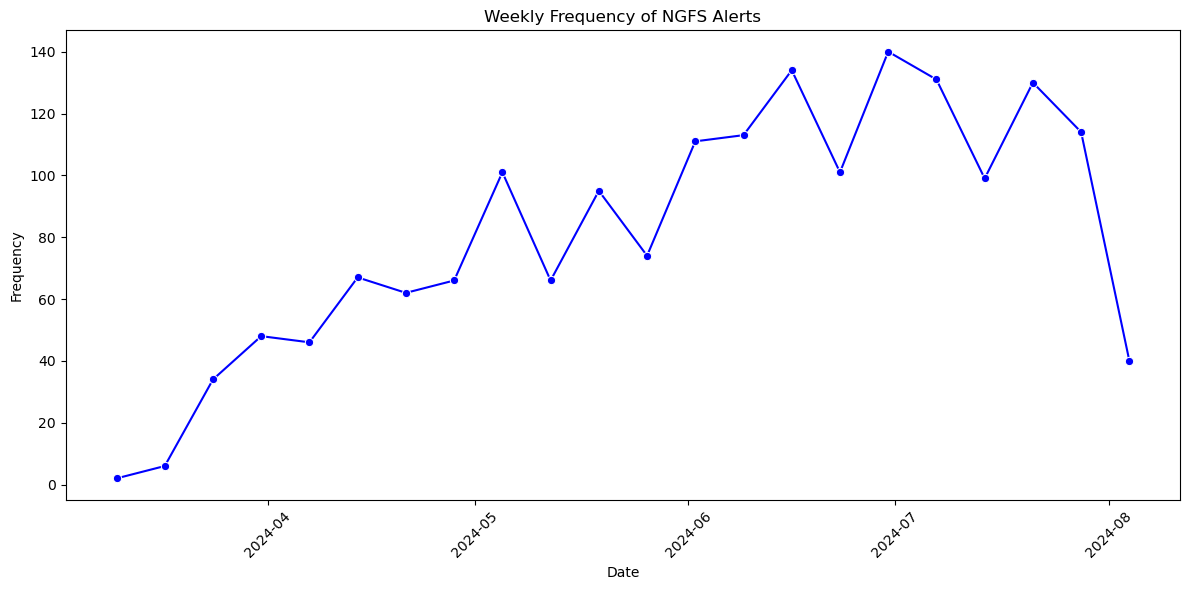

In [90]:
# Set 'timestamp' as the index
ngfs_df.set_index('timestamp', inplace=True)

# Resample data by week and count occurrences
weekly_counts = ngfs_df.resample('W').size()

# Plotting the frequency chart
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_counts.index, y=weekly_counts.values, marker='o', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Weekly Frequency of NGFS Alerts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

## Null Pushed/Reason Counts

In [97]:
# Convert 'timestamp' column to datetime
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Extract time from the timestamp
combined_df['time'] = combined_df['timestamp'].dt.time

# Define the time range (7 AM to 9 PM)
start_time = pd.to_datetime('07:00:00').time()
end_time = pd.to_datetime('21:00:00').time()

# Identify entries within and outside the specified time range
within_time_range = combined_df['time'].between(start_time, end_time)
outside_time_range = ~within_time_range

# Check for empty strings (strip leading/trailing whitespace and check for empty strings)
empty_string_within_time_range = combined_df[within_time_range]['pushed/reason'].str.strip() == ''
empty_string_outside_time_range = combined_df[outside_time_range]['pushed/reason'].str.strip() == ''

# Count empty strings in each group
empty_strings_within_time_range = empty_string_within_time_range.sum()
empty_strings_outside_time_range = empty_string_outside_time_range.sum()

# Count total entries in each group
total_within_time_range = within_time_range.sum()
total_outside_time_range = outside_time_range.sum()

# Calculate percentages
percentage_empty_strings_within_time_range = (empty_strings_within_time_range / total_within_time_range) * 100 if total_within_time_range > 0 else 0
percentage_empty_strings_outside_time_range = (empty_strings_outside_time_range / total_outside_time_range) * 100 if total_outside_time_range > 0 else 0

# Create a summary table with formatted percentages
summary_table = pd.DataFrame({
    'Time Range': ['7 AM - 9 PM', 'Outside 7 AM - 9 PM'],
    'Total Entries': [total_within_time_range, total_outside_time_range],
    'Null Pushed/Reason': [empty_strings_within_time_range, empty_strings_outside_time_range],
    'Percentage Null': [
        f"{percentage_empty_strings_within_time_range:.2f}%",
        f"{percentage_empty_strings_outside_time_range:.2f}%"
    ]
})

print(summary_table)

            Time Range  Total Entries  Null Pushed/Reason Percentage Null
0          7 AM - 9 PM          21417                5764          26.91%
1  Outside 7 AM - 9 PM           5647                5256          93.08%


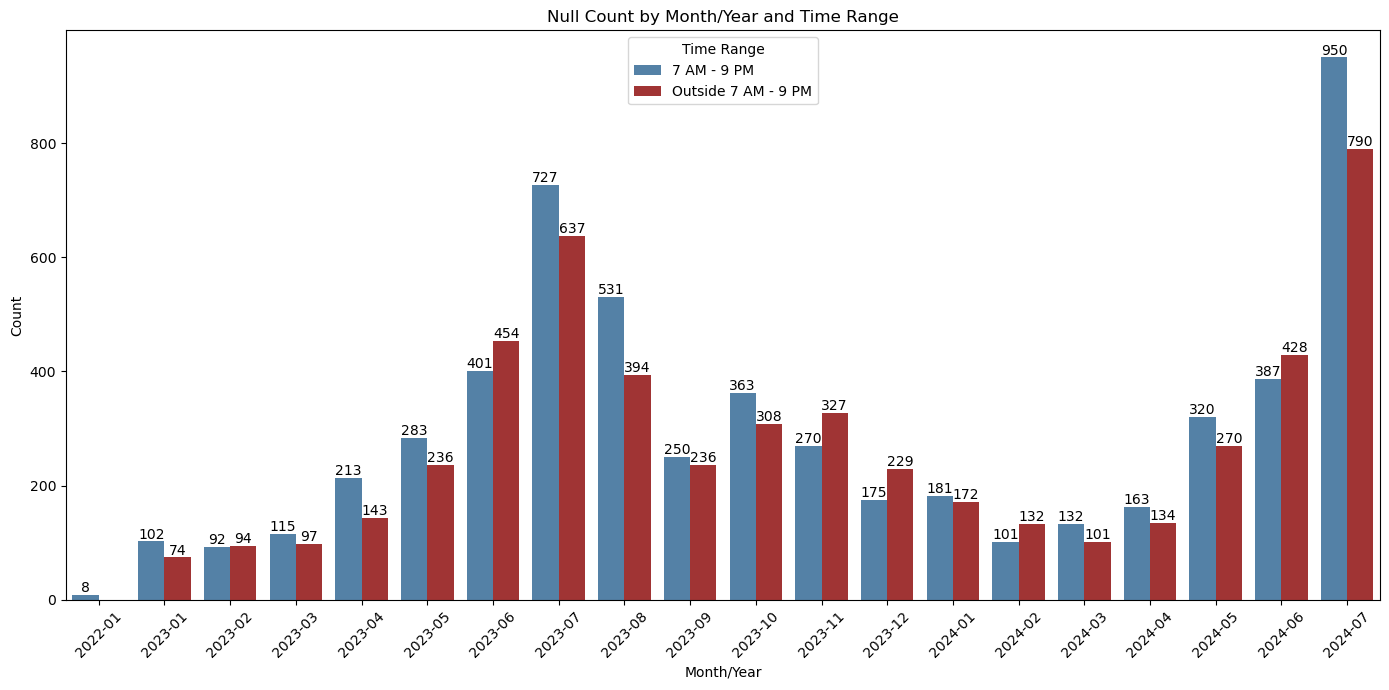

In [110]:
# Extract month and year
combined_df['month_year'] = combined_df['timestamp'].dt.to_period('M')

# Extract time from the timestamp
combined_df['time'] = combined_df['timestamp'].dt.time

# Define the time range (7 AM to 9 PM)
start_time = pd.to_datetime('07:00:00').time()
end_time = pd.to_datetime('21:00:00').time()

# Identify entries within and outside the specified time range
combined_df['within_time_range'] = combined_df['time'].between(start_time, end_time)
combined_df['time_range'] = combined_df['within_time_range'].map({True: '7 AM - 9 PM', False: 'Outside 7 AM - 9 PM'})

# Check for empty strings (strip leading/trailing whitespace and check for empty strings)
combined_df['empty_string'] = combined_df['pushed/reason'].str.strip() == ''

# Count empty strings by month/year and time range
count_empty_strings = combined_df.groupby(['month_year', 'time_range'])['empty_string'].sum().reset_index()

# Count total entries by month/year and time range
total_entries = combined_df.groupby(['month_year', 'time_range']).size().reset_index(name='total_entries')

# Merge counts with total entries
count_empty_strings = pd.merge(count_empty_strings, total_entries, on=['month_year', 'time_range'])

# Plotting
plt.figure(figsize=(14, 7))

# Create bar plot with side-by-side bars
ax = sns.barplot(data=count_empty_strings, x='month_year', y='empty_string', hue='time_range', palette={'7 AM - 9 PM': 'steelblue', 'Outside 7 AM - 9 PM': 'firebrick'})

plt.title('Null Count by Month/Year and Time Range')
plt.xticks(rotation=45)
plt.xlabel('Month/Year')
plt.ylabel('Count')

# Add counts on top of bars
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.legend(title='Time Range')
plt.tight_layout()
plt.show()

## Spatial Join - All Alerts

In [12]:
def match_alerts(df, buffer_distance_km, time_window_hours):
    """
    Match alerts from NGFS with IRWIN and PulsePoint based on proximity and time window.

    Parameters:
    - df: DataFrame containing alerts data.
    - buffer_distance_km: Distance in kilometers for spatial proximity.
    - time_window_hours: Time window in hours for temporal proximity.

    Returns:
    - filtered_results: DataFrame containing matched alerts within the specified parameters.
    """

    # Filter the dataframe for NGFS, IRWIN, and PulsePoint
    ngfs_goes_df = df[df['type'].isin(['NGFS', 'GOES'])]
    other_df = df[~df['type'].isin(['NGFS', 'GOES'])]

    # Turn into GeoDataFrame
    ngfs_goes_gdf = gpd.GeoDataFrame(ngfs_goes_df, geometry=gpd.points_from_xy(ngfs_goes_df.lon, ngfs_goes_df.lat))
    other_gdf = gpd.GeoDataFrame(other_df, geometry=gpd.points_from_xy(other_df.lon, other_df.lat))

    # Set the CRS (Coordinate Reference System) to EPSG:4326 (WGS84)
    ngfs_goes_gdf.crs = "EPSG:4326"
    other_gdf.crs = "EPSG:4326"

    # Convert to EPSG:3857 for distance calculation (meters)
    ngfs_goes_gdf = ngfs_goes_gdf.to_crs(epsg=3857)
    other_gdf = other_gdf.to_crs(epsg=3857)

    # Perform spatial join
    buffered_ngfs = ngfs_goes_gdf.copy()
    buffered_ngfs['geometry'] = buffered_ngfs.geometry.buffer(buffer_distance_km * 1000)  # Convert km to meters

    joined_gdf = gpd.sjoin(other_gdf, buffered_ngfs, op='within')

    # Rename columns
    columns = joined_gdf.columns
    new_columns = []

    for col in columns:
        if col.endswith('_left'):
            new_columns.append(f'ngfs_{col[:-5]}')
        elif col.endswith('_right'):
            new_columns.append(f'irwin_pp_{col[:-6]}')
        else:
            new_columns.append(col)

    # Apply the new column names
    joined_gdf.columns = new_columns

    # Filter by time window
    time_window = pd.Timedelta(hours=time_window_hours)

    # Create a function to filter by time window
    def filter_by_time(row):
        ngfs_time = row['ngfs_timestamp']
        alert_time = row['irwin_pp_timestamp']
        return abs((ngfs_time - alert_time).total_seconds()) <= time_window.total_seconds()

    # Apply the time window filter
    filtered_results = joined_gdf[joined_gdf.apply(filter_by_time, axis=1)]

    return filtered_results


In [13]:
match_alerts(combined_df, buffer_distance_km=5, time_window_hours=1)

,ngfs_id,ngfs_type,ngfs_timestamp,ngfs_message,ngfs_agency,ngfs_DPA,ngfs_county,ngfs_OES region,ngfs_lat/lon,ngfs_pushed/reason,...,irwin_pp_lat/lon,irwin_pp_pushed/reason,irwin_pp_modeler,"irwin_pp_notes (fire name, other)",irwin_pp_lat,irwin_pp_lon,irwin_pp_source_folder,irwin_pp_source_file,irwin_pp_date,irwin_pp_time
101,"2023-09-26 12:41:00Riverside33.7636988880488, ...",IRWIN,2023-09-26 12:41:00,"RRU, JUNIPER IC Riverside",RRU,STATE,Riverside,6,"33.7636988880488, -117.08441796646",Knockdowns,...,"33.7492, -117.0757",Knockdowns,Chesa,NaN,33.7492,-117.0757,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,12:42:00
106,"2023-09-26 14:11:00Riverside33.7749828783464, ...",IRWIN,2023-09-26 14:11:00,"RRU, MEADOW IC Riverside",RRU,STATE,Riverside,6,"33.7749828783464, -117.28406200181",,...,"33.7661, -117.2912",,NaN,NaN,33.7661,-117.2912,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,14:17:00
153,2023-09-27 18:01:00San Luis Obispo35.734418907...,IRWIN,2023-09-27 18:01:00,"SLU, SHANDON IC San Luis Obispo",SLU,STATE,San Luis Obispo,1,"35.7344189074981, -120.284385669971",Other - Enter reason,...,"35.7389, -120.2646",Knockdowns,Treva,NaN,35.7389,-120.2646,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-27,17:45:00
175,"2023-09-28 14:06:00Riverside33.5376218749237, ...",IRWIN,2023-09-28 14:06:00,"RRU, REED VALLEY RD AGUA IC Riverside",RRU,STATE,Riverside,6,"33.5376218749237, -116.84091590655",Pushed,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
178,"2023-09-28 15:01:00Riverside33.54003407976618,...",Intterra FIRIS,2023-09-28 15:01:00,3acres CA-RRU-REED-N43U_092820232145Z PERIM,RRU,STATE,Riverside,6,"33.54003407976618, -116.83801427860558",,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28910,"2023-10-30 12:40:00Riverside33.4382118641659, ...",IRWIN,2023-10-30 12:40:00,"RRU, HIGHLANDS RD / AGUANGA RANCHOS RD IC Rive...",RRU,STATE,Riverside,6.0,"33.4382118641659, -116.823081895812",Pushed,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28917,2023-10-30 13:49:00Riverside33.438715595271134...,Intterra FIRIS,2023-10-30 13:49:00,27acres CA-RRU-HIGHLANDS-N43U_103020232017Z PERIM,RRU,STATE,Riverside,6.0,"33.438715595271134, -116.83036391264216",,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28926,2023-10-30 14:41:00San Luis Obispo35.293249883...,IRWIN,2023-10-30 14:41:00,"SLU, DIABLO IC San Luis Obispo",SLU,STATE,San Luis Obispo,1.0,"35.2932498831439, -119.982653580228",,...,"35.2979, -119.9843",Pushed,NaN,NaN,35.2979,-119.9843,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,15:04:00
28929,2023-10-30 14:58:00San Luis Obispo35.279857840...,IRWIN,2023-10-30 14:58:00,"SLO, LIZZIE IC San Luis Obispo",SLO,LOCAL,San Luis Obispo,1.0,"35.2798578404055, -120.648420684485",Pushed,...,"35.2778, -120.6462",,NaN,NaN,35.2778,-120.6462,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,14:57:00


### 5 km buffer & 1 hour time window

In [14]:
km_5_hr_1 = match_alerts(combined_df, buffer_distance_km=5, time_window_hours=1)
km_5_hr_1

,ngfs_id,ngfs_type,ngfs_timestamp,ngfs_message,ngfs_agency,ngfs_DPA,ngfs_county,ngfs_OES region,ngfs_lat/lon,ngfs_pushed/reason,...,irwin_pp_lat/lon,irwin_pp_pushed/reason,irwin_pp_modeler,"irwin_pp_notes (fire name, other)",irwin_pp_lat,irwin_pp_lon,irwin_pp_source_folder,irwin_pp_source_file,irwin_pp_date,irwin_pp_time
101,"2023-09-26 12:41:00Riverside33.7636988880488, ...",IRWIN,2023-09-26 12:41:00,"RRU, JUNIPER IC Riverside",RRU,STATE,Riverside,6,"33.7636988880488, -117.08441796646",Knockdowns,...,"33.7492, -117.0757",Knockdowns,Chesa,NaN,33.7492,-117.0757,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,12:42:00
106,"2023-09-26 14:11:00Riverside33.7749828783464, ...",IRWIN,2023-09-26 14:11:00,"RRU, MEADOW IC Riverside",RRU,STATE,Riverside,6,"33.7749828783464, -117.28406200181",,...,"33.7661, -117.2912",,NaN,NaN,33.7661,-117.2912,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,14:17:00
153,2023-09-27 18:01:00San Luis Obispo35.734418907...,IRWIN,2023-09-27 18:01:00,"SLU, SHANDON IC San Luis Obispo",SLU,STATE,San Luis Obispo,1,"35.7344189074981, -120.284385669971",Other - Enter reason,...,"35.7389, -120.2646",Knockdowns,Treva,NaN,35.7389,-120.2646,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-27,17:45:00
175,"2023-09-28 14:06:00Riverside33.5376218749237, ...",IRWIN,2023-09-28 14:06:00,"RRU, REED VALLEY RD AGUA IC Riverside",RRU,STATE,Riverside,6,"33.5376218749237, -116.84091590655",Pushed,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
178,"2023-09-28 15:01:00Riverside33.54003407976618,...",Intterra FIRIS,2023-09-28 15:01:00,3acres CA-RRU-REED-N43U_092820232145Z PERIM,RRU,STATE,Riverside,6,"33.54003407976618, -116.83801427860558",,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28910,"2023-10-30 12:40:00Riverside33.4382118641659, ...",IRWIN,2023-10-30 12:40:00,"RRU, HIGHLANDS RD / AGUANGA RANCHOS RD IC Rive...",RRU,STATE,Riverside,6.0,"33.4382118641659, -116.823081895812",Pushed,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28917,2023-10-30 13:49:00Riverside33.438715595271134...,Intterra FIRIS,2023-10-30 13:49:00,27acres CA-RRU-HIGHLANDS-N43U_103020232017Z PERIM,RRU,STATE,Riverside,6.0,"33.438715595271134, -116.83036391264216",,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28926,2023-10-30 14:41:00San Luis Obispo35.293249883...,IRWIN,2023-10-30 14:41:00,"SLU, DIABLO IC San Luis Obispo",SLU,STATE,San Luis Obispo,1.0,"35.2932498831439, -119.982653580228",,...,"35.2979, -119.9843",Pushed,NaN,NaN,35.2979,-119.9843,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,15:04:00
28929,2023-10-30 14:58:00San Luis Obispo35.279857840...,IRWIN,2023-10-30 14:58:00,"SLO, LIZZIE IC San Luis Obispo",SLO,LOCAL,San Luis Obispo,1.0,"35.2798578404055, -120.648420684485",Pushed,...,"35.2778, -120.6462",,NaN,NaN,35.2778,-120.6462,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,14:57:00


### 5 km buffer & 3 hour time window

In [15]:
km_5_hr_3 = match_alerts(combined_df, buffer_distance_km=5, time_window_hours=3)
km_5_hr_3.shape

(1342, 38)

### 5 km buffer & 24 hour time window

In [16]:
km_5_hr_24 = match_alerts(combined_df, buffer_distance_km=5, time_window_hours=24)
km_5_hr_24.shape

(2008, 38)

###  10 km buffer & 1 hour time window

In [17]:
km_10_hr_1 = match_alerts(combined_df, buffer_distance_km=10, time_window_hours=1)
km_10_hr_1.shape

(853, 38)

###  10 km buffer & 3 hour time window

In [18]:
km_10_hr_3 = match_alerts(combined_df, buffer_distance_km=10, time_window_hours=3)
km_10_hr_3

,ngfs_id,ngfs_type,ngfs_timestamp,ngfs_message,ngfs_agency,ngfs_DPA,ngfs_county,ngfs_OES region,ngfs_lat/lon,ngfs_pushed/reason,...,irwin_pp_lat/lon,irwin_pp_pushed/reason,irwin_pp_modeler,"irwin_pp_notes (fire name, other)",irwin_pp_lat,irwin_pp_lon,irwin_pp_source_folder,irwin_pp_source_file,irwin_pp_date,irwin_pp_time
101,"2023-09-26 12:41:00Riverside33.7636988880488, ...",IRWIN,2023-09-26 12:41:00,"RRU, JUNIPER IC Riverside",RRU,STATE,Riverside,6,"33.7636988880488, -117.08441796646",Knockdowns,...,"33.7492, -117.0757",Knockdowns,Chesa,NaN,33.7492,-117.0757,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,12:42:00
106,"2023-09-26 14:11:00Riverside33.7749828783464, ...",IRWIN,2023-09-26 14:11:00,"RRU, MEADOW IC Riverside",RRU,STATE,Riverside,6,"33.7749828783464, -117.28406200181",,...,"33.7661, -117.2912",,NaN,NaN,33.7661,-117.2912,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-26,14:17:00
153,2023-09-27 18:01:00San Luis Obispo35.734418907...,IRWIN,2023-09-27 18:01:00,"SLU, SHANDON IC San Luis Obispo",SLU,STATE,San Luis Obispo,1,"35.7344189074981, -120.284385669971",Other - Enter reason,...,"35.7389, -120.2646",Knockdowns,Treva,NaN,35.7389,-120.2646,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-27,17:45:00
175,"2023-09-28 14:06:00Riverside33.5376218749237, ...",IRWIN,2023-09-28 14:06:00,"RRU, REED VALLEY RD AGUA IC Riverside",RRU,STATE,Riverside,6,"33.5376218749237, -116.84091590655",Pushed,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
178,"2023-09-28 15:01:00Riverside33.54003407976618,...",Intterra FIRIS,2023-09-28 15:01:00,3acres CA-RRU-REED-N43U_092820232145Z PERIM,RRU,STATE,Riverside,6,"33.54003407976618, -116.83801427860558",,...,"33.5398, -116.8413",Other - Enter reason,Rawaf,Repeat Reed IC,33.5398,-116.8413,2023_09,FIRIS_Modeling_Logs_2023_09 - Days 25-30.csv,2023-09-28,14:19:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28931,"2023-10-30 15:02:00Riverside33.4443088947364, ...",Intterra FIRIS,2023-10-30 15:02:00,326acres CA-RRU-HIGHLANDS-N43U_103020232017Z P...,RRU,STATE,Riverside,6.0,"33.4443088947364, -116.84064099430414",Pushed,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28932,"2023-10-30 15:02:00Riverside33.44247300897906,...",Intterra FIRIS,2023-10-30 15:02:00,326acres CA-RRU-HIGHLANDS-N43U_103020232017Z P...,RRU,STATE,Riverside,6.0,"33.44247300897906, -116.8475985379843",Pushed,...,"33.4441, -116.8196",,NaN,NaN,33.4441,-116.8196,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,12:50:00
28942,2023-10-30 16:15:00San Luis Obispo35.281583790...,Intterra FIRIS,2023-10-30 16:15:00,100acres CA-SLU-LIZZIE-N43U_103020232211Z PERIM,NaN,NaN,San Luis Obispo,1.0,"35.281583790434446, -120.64035169597595",,...,"35.2778, -120.6462",,NaN,NaN,35.2778,-120.6462,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,14:57:00
28943,2023-10-30 16:32:00San Luis Obispo35.301327841...,IRWIN,2023-10-30 16:32:00,"SLC, HIGHLAND IC San Luis Obispo",SLC,LOCAL,San Luis Obispo,1.0,"35.3013278411836, -120.669306689751",,...,"35.2778, -120.6462",,NaN,NaN,35.2778,-120.6462,2023_10,FIRIS_Modeling_Logs_2023_10 - Days 30-31.csv,2023-10-30,14:57:00


###  10 km buffer & 24 hour time window

In [19]:
km_10_hr_24 = match_alerts(combined_df, buffer_distance_km=10, time_window_hours=24)
km_10_hr_24.shape

(2652, 38)

##  Spatial Join - NGFS/GOES to Other Alerts Matching¶

In a new table create fields for:

Date/Day-Incident 

Name-PP 

time-Irwin 

Time-NGFS Time

mark which alert came in first, 

and what was the time difference

In [20]:
# Convert DataFrames to GeoDataFrames
def convert_to_geodataframe(df, crs="EPSG:4326"):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.lon, df.lat),
        crs=crs
    )
    return gdf

# Convert to EPSG:3857 for distance calculation (meters)
def reproject_to_3857(gdf):
    return gdf.to_crs(epsg=3857)

# Function to perform spatial join and time filtering
def spatial_join_and_filter(ngfs_goes_gdf, irwin_pulsepoint_gdf, buffer_distance_km=10, time_minutes=180):
    # Reproject GeoDataFrames to EPSG:3857 for accurate distance calculations
    ngfs_goes_gdf = reproject_to_3857(ngfs_goes_gdf)
    irwin_pulsepoint_gdf = reproject_to_3857(irwin_pulsepoint_gdf)

    # Create buffer around NGFS and GOES points
    buffered_ngfs_goes_gdf = ngfs_goes_gdf.copy()
    buffered_ngfs_goes_gdf['geometry'] = buffered_ngfs_goes_gdf.geometry.buffer(buffer_distance_km * 1000)  # Convert km to meters

    # Perform spatial join
    joined_gdf = gpd.sjoin(irwin_pulsepoint_gdf, buffered_ngfs_goes_gdf, how='inner', op='within')
    
    # Initialize a list to keep track of valid alerts
    matches = []

    # Filter based on time difference
    for _, row in joined_gdf.iterrows():
        ngfs_goes_time = row['timestamp_right']
        other_time = row['timestamp_left']
        time_diff_minutes = abs((ngfs_goes_time - other_time).total_seconds() / 60)  # Time difference in minutes
        if time_diff_minutes <= time_minutes:
            ngfs_goes_first = ngfs_goes_time < other_time
            irwin_pulsepoint_first = not ngfs_goes_first
            matches.append({
                'incident_date': row['date_right'],
                'ngfs_goes_type': row['type_right'],
                'ngfs_goes_timestamp': row['timestamp_right'],
                'ngfs_goes_name': row['message_right'], 
                'irwin_pulsepoint_type': row['type_left'],
                'irwin_pulsepoint_timestamp': row['timestamp_left'],
                'irwin_pulsepoint_name': row['message_left'], 
                'ngfs_goes_came_first': ngfs_goes_first,
                'irwin_pulsepoint_came_first': irwin_pulsepoint_first,
                'time_difference_minutes': time_diff_minutes
            })
    
    return pd.DataFrame(matches)

In [21]:
# Convert DataFrames to GeoDataFrames
ngfs_goes_df = combined_df[combined_df['type'].isin(['NGFS', 'GOES'])]
irwin_pulsepoint_df = combined_df[combined_df['type'].isin(['IRWIN', 'PulsePoint'])]

ngfs_goes_gdf = convert_to_geodataframe(ngfs_goes_df)
irwin_pulsepoint_gdf = convert_to_geodataframe(irwin_pulsepoint_df)

# Perform spatial join and filter by time
results_df = spatial_join_and_filter(ngfs_goes_gdf, irwin_pulsepoint_gdf)

# Display results
results_df.head()

,incident_date,ngfs_goes_type,ngfs_goes_timestamp,ngfs_goes_name,irwin_pulsepoint_type,irwin_pulsepoint_timestamp,irwin_pulsepoint_name,ngfs_goes_came_first,irwin_pulsepoint_came_first,time_difference_minutes
0,2023-09-26,GOES,2023-09-26 12:42:00,"Processed, Riverside County, 41 MW",IRWIN,2023-09-26 12:41:00,"RRU, JUNIPER IC Riverside",False,True,1.0
1,2023-09-26,GOES,2023-09-26 14:17:00,"Processed, Riverside County, 56 MW",IRWIN,2023-09-26 14:11:00,"RRU, MEADOW IC Riverside",False,True,6.0
2,2023-09-27,GOES,2023-09-27 17:45:00,"Processed, San Luis Obispo County, 26 MW",IRWIN,2023-09-27 18:01:00,"SLU, SHANDON IC San Luis Obispo",True,False,16.0
3,2023-09-28,GOES,2023-09-28 14:19:00,"Processed, Riverside County, 46 MW",IRWIN,2023-09-28 14:06:00,"RRU, REED VALLEY RD AGUA IC Riverside",False,True,13.0
4,2023-09-08,GOES,2023-09-08 19:11:00,"Processed, Kern County, 28 MW",IRWIN,2023-09-08 19:39:00,"KRN, BAY IC Kern",True,False,28.0


### Visualization All Alerts

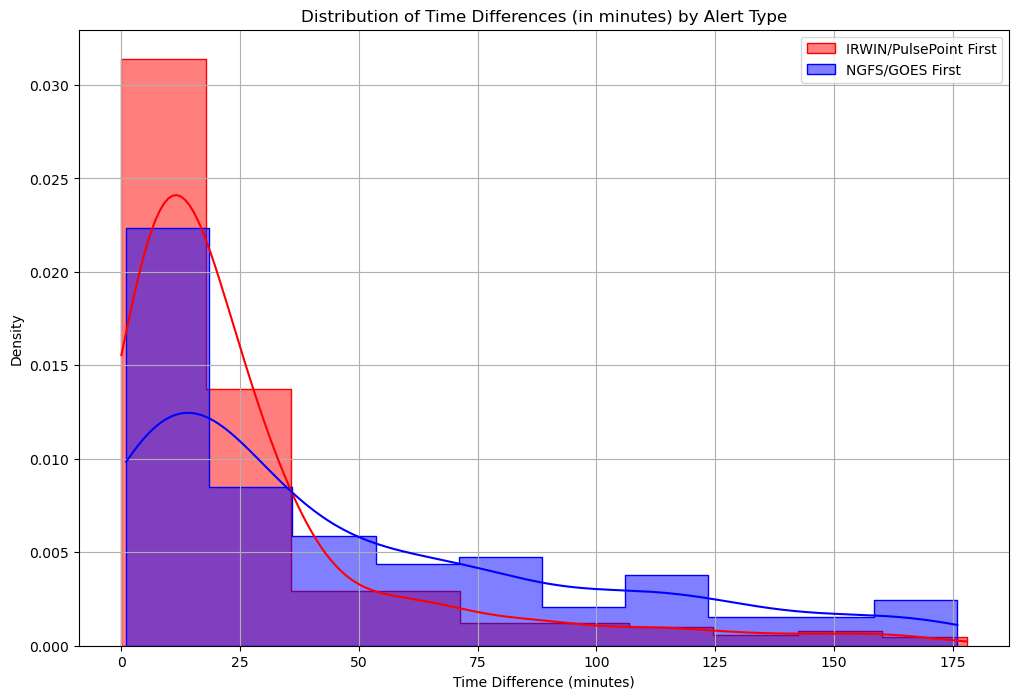

In [22]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Plot histogram for IRWIN/PulsePoint first
sns.histplot(results_df[results_df['irwin_pulsepoint_came_first']]['time_difference_minutes'], 
             kde=True, color='red', bins=10, label='IRWIN/PulsePoint First', element='step', stat='density')

# Plot histogram for NGFS/GOES first
sns.histplot(results_df[results_df['ngfs_goes_came_first']]['time_difference_minutes'], 
             kde=True, color='blue', bins=10, label='NGFS/GOES First', element='step', stat='density')

# Add titles and labels
plt.title('Distribution of Time Differences (in minutes) by Alert Type')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Density')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [23]:
# Calculate median and average time difference for NGFS/GOES came first
ngfs_goes_first_stats = results_df[results_df['ngfs_goes_came_first']]['time_difference_minutes'].agg(['median', 'mean'])
ngfs_goes_count = results_df['ngfs_goes_came_first'].sum()

# Calculate median and average time difference for IRWIN/PulsePoint came first
irwin_pulsepoint_first_stats = results_df[results_df['irwin_pulsepoint_came_first']]['time_difference_minutes'].agg(['median', 'mean'])
irwin_pulsepoint_count = results_df['irwin_pulsepoint_came_first'].sum()

# Calculate total count for percentage calculations
total_count = len(results_df)

# Create a DataFrame to display the results
stats_df = pd.DataFrame({
    'Event Order': ['NGFS/GOES First', 'IRWIN/PulsePoint First'],
    'Count': [ngfs_goes_count, irwin_pulsepoint_count],
    'Percentage': [f"{ngfs_goes_count / total_count * 100:.2f}%", f"{irwin_pulsepoint_count / total_count * 100:.2f}%"],
    'Median Time Difference (minutes)': [ngfs_goes_first_stats['median'], irwin_pulsepoint_first_stats['median']],
    'Average Time Difference (minutes)': [ngfs_goes_first_stats['mean'], irwin_pulsepoint_first_stats['mean']]
})

stats_df

,Event Order,Count,Percentage,Median Time Difference (minutes),Average Time Difference (minutes)
0,NGFS/GOES First,302,37.52%,29.0,48.781457
1,IRWIN/PulsePoint First,503,62.48%,14.0,27.194831


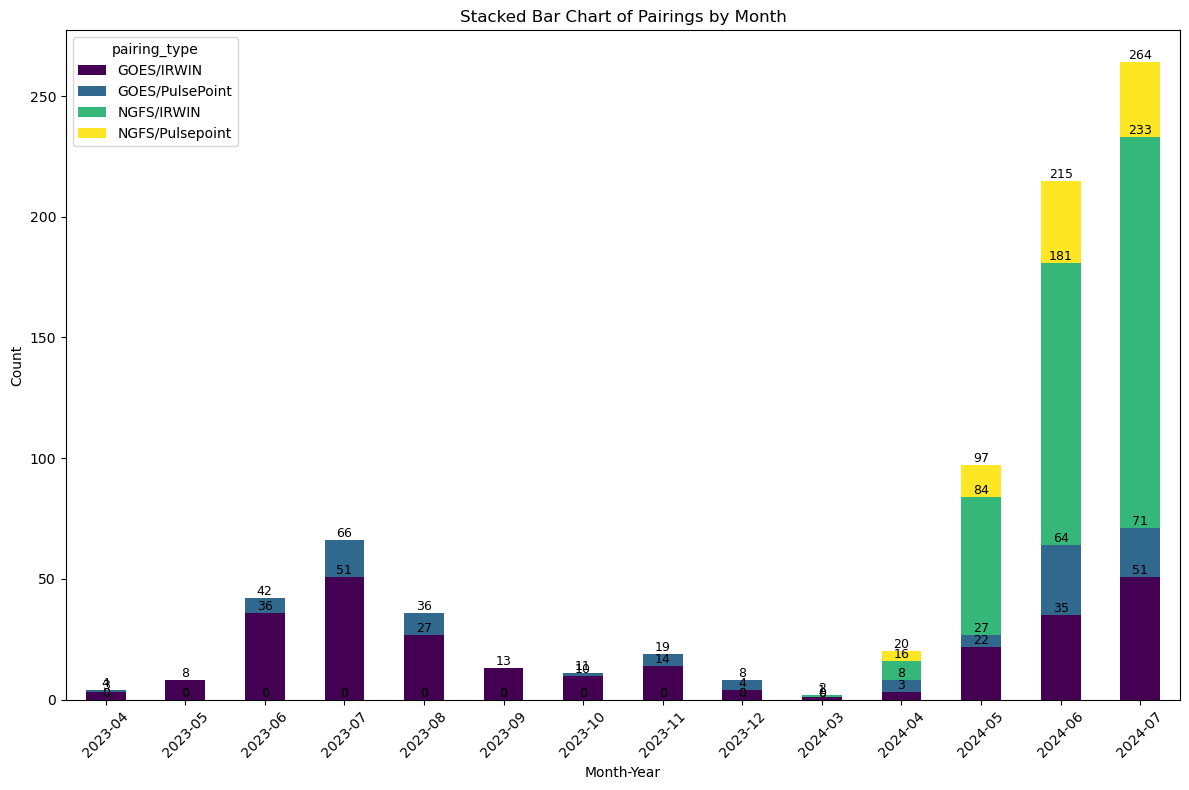

In [46]:
results_df['incident_date'] = pd.to_datetime(results_df['incident_date'])

# Extract month and year from the 'incident_date' column
results_df['month_year'] = results_df['incident_date'].dt.to_period('M')

# Define pairing types
def categorize_pairing(row):
    if row['ngfs_goes_type'] == 'GOES' and row['irwin_pulsepoint_type'] == 'IRWIN':
        return 'GOES/IRWIN'
    elif row['ngfs_goes_type'] == 'NGFS' and row['irwin_pulsepoint_type'] == 'IRWIN':
        return 'NGFS/IRWIN'
    elif row['ngfs_goes_type'] == 'GOES' and row['irwin_pulsepoint_type'] != 'IRWIN':
        return 'GOES/PulsePoint'
    elif row['ngfs_goes_type'] != 'GOES' and row['irwin_pulsepoint_type'] != 'IRWIN':
        return 'NGFS/Pulsepoint'
    return 'Other'

results_df['pairing_type'] = results_df.apply(categorize_pairing, axis=1)

# Count occurrences by month-year and pairing type
counts = results_df.groupby(['month_year', 'pairing_type']).size().unstack(fill_value=0)

# Plotting
ax = counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

# Add counts on top of the bars
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=9)

plt.title('Stacked Bar Chart of Pairings by Month')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

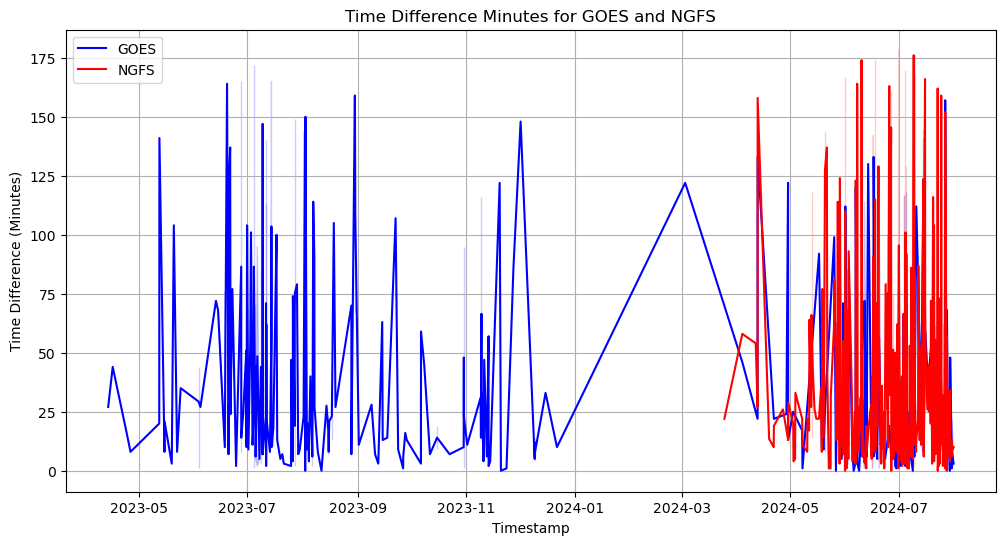

In [52]:
results_df['ngfs_goes_timestamp'] = pd.to_datetime(results_df['ngfs_goes_timestamp'])

# Filter the data for GOES and NGFS
goes_data = results_df[results_df['ngfs_goes_type'] == 'GOES']
ngfs_data = results_df[results_df['ngfs_goes_type'] == 'NGFS']

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot GOES data
sns.lineplot(x='ngfs_goes_timestamp', y='time_difference_minutes', data=goes_data, label='GOES', color='blue')

# Plot NGFS data
sns.lineplot(x='ngfs_goes_timestamp', y='time_difference_minutes', data=ngfs_data, label='NGFS', color='red')

# Customize the plot
plt.title('Time Difference Minutes for GOES and NGFS')
plt.xlabel('Timestamp')
plt.ylabel('Time Difference (Minutes)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Analysis on IRWIN and NGFS alerts

In [24]:
ngfs_irwin = results_df[(results_df['ngfs_goes_type'] == 'NGFS') & (results_df['irwin_pulsepoint_type'] == 'IRWIN')]

ngfs_irwin = ngfs_irwin.copy()

ngfs_irwin.rename(columns={'irwin_pulsepoint_name': 'irwin_name'}, inplace=True)
ngfs_irwin.drop(columns=['ngfs_goes_name'], inplace=True)
ngfs_irwin.head()

,incident_date,ngfs_goes_type,ngfs_goes_timestamp,irwin_pulsepoint_type,irwin_pulsepoint_timestamp,irwin_name,ngfs_goes_came_first,irwin_pulsepoint_came_first,time_difference_minutes
164,2024-05-20,NGFS,2024-05-20 09:41:00,IRWIN,2024-05-20 07:50:00,"KRN, WIND IC Kern",False,True,111.0
165,2024-05-21,NGFS,2024-05-21 11:16:00,IRWIN,2024-05-21 13:33:00,"MDF, VALLEY IC Modoc",True,False,137.0
166,2024-05-21,NGFS,2024-05-21 16:45:00,IRWIN,2024-05-21 17:26:00,"MDC, AVE 25 / RD 12 IC Madera",True,False,41.0
167,2024-05-22,NGFS,2024-05-22 13:26:00,IRWIN,2024-05-22 13:25:00,"FKU, LOS GATOS CREEK RD /S DERRICK BLVD IC Fresno",False,True,1.0
168,2024-05-23,NGFS,2024-05-23 13:31:00,IRWIN,2024-05-23 13:30:00,"ORO, GRAND IC Butte",False,True,1.0


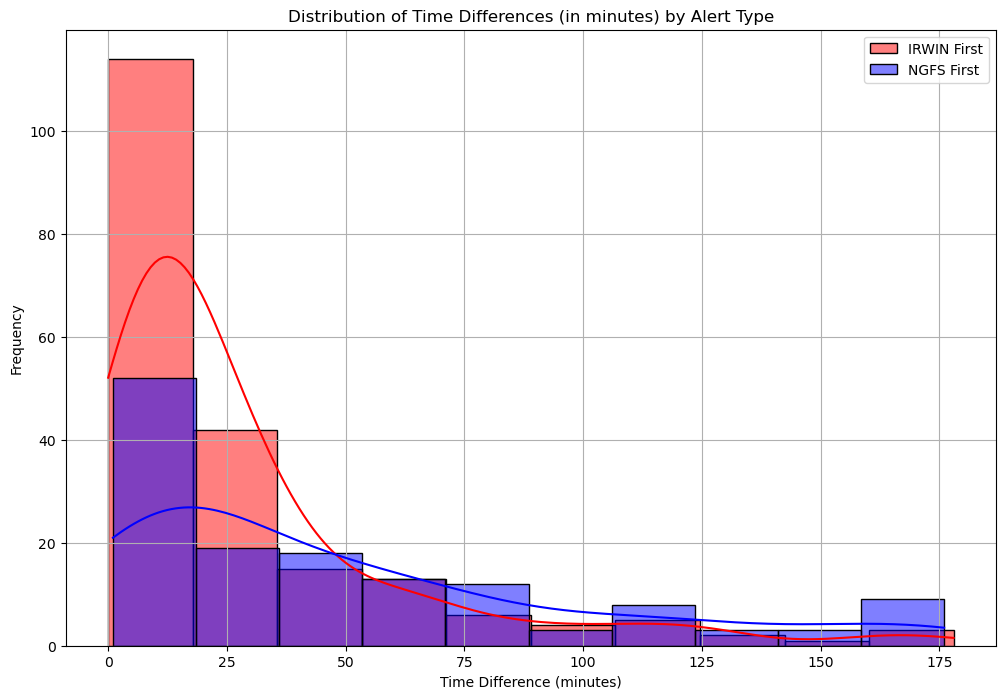

In [25]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Plot histogram for IRWIN/PulsePoint first
sns.histplot(ngfs_irwin[ngfs_irwin['irwin_pulsepoint_came_first']]['time_difference_minutes'], 
             kde=True, color='red', bins=10, label='IRWIN First')

# Plot histogram for NGFS/GOES first
sns.histplot(ngfs_irwin[ngfs_irwin['ngfs_goes_came_first']]['time_difference_minutes'], 
             kde=True, color='blue', bins=10, label='NGFS First')

# Add titles and labels
plt.title('Distribution of Time Differences (in minutes) by Alert Type')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [26]:
# Calculate median and average time difference for NGFS/GOES came first
ngfs_goes_first_stats = ngfs_irwin[ngfs_irwin['ngfs_goes_came_first']]['time_difference_minutes'].agg(['median', 'mean'])
ngfs_goes_count = ngfs_irwin['ngfs_goes_came_first'].sum()

# Calculate median and average time difference for IRWIN/PulsePoint came first
irwin_pulsepoint_first_stats = ngfs_irwin[ngfs_irwin['irwin_pulsepoint_came_first']]['time_difference_minutes'].agg(['median', 'mean'])
irwin_pulsepoint_count = ngfs_irwin['irwin_pulsepoint_came_first'].sum()

# Calculate total count for percentage calculations
total_count = len(ngfs_irwin)

# Create a DataFrame to display the results
stats_df = pd.DataFrame({
    'Event Order': ['NGFS First', 'IRWIN First'],
    'Count': [ngfs_goes_count, irwin_pulsepoint_count],
    'Percentage': [f"{ngfs_goes_count / total_count * 100:.2f}%", f"{irwin_pulsepoint_count / total_count * 100:.2f}%"],
    'Median Time Difference (minutes)': [ngfs_goes_first_stats['median'], irwin_pulsepoint_first_stats['median']],
    'Average Time Difference (minutes)': [ngfs_goes_first_stats['mean'], irwin_pulsepoint_first_stats['mean']]
})

# Display the table
stats_df

,Event Order,Count,Percentage,Median Time Difference (minutes),Average Time Difference (minutes)
0,NGFS First,140,40.58%,32.0,50.121429
1,IRWIN First,205,59.42%,16.0,28.712195


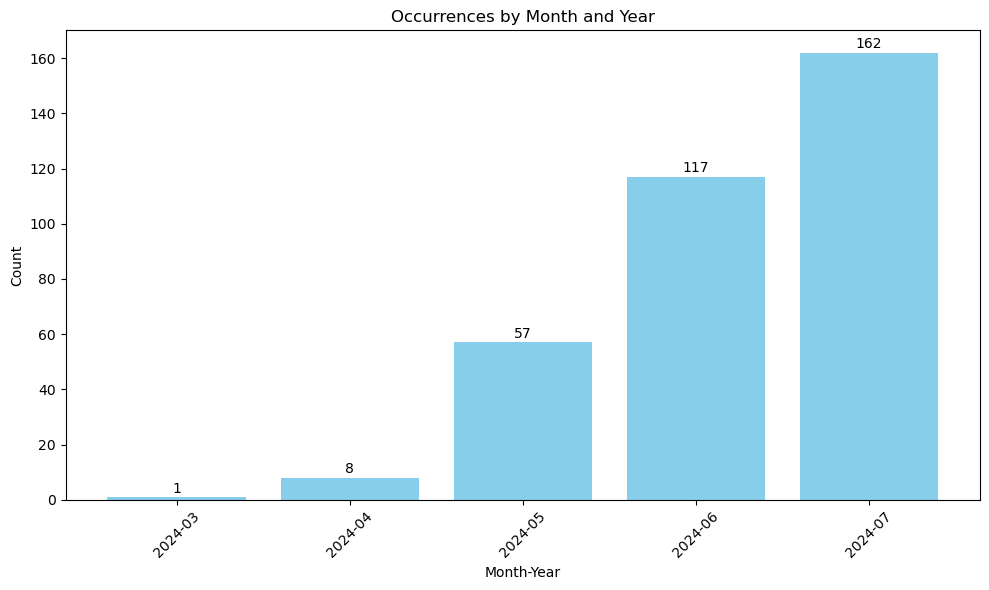

In [39]:
ngfs_irwin['ngfs_goes_timestamp'] = pd.to_datetime(ngfs_irwin['ngfs_goes_timestamp'])

# Extract month and year from the 'ngfs_goes_timestamp' column
ngfs_irwin['month_year'] = ngfs_irwin['ngfs_goes_timestamp'].dt.to_period('M')

# Count occurrences by month and year
counts = ngfs_irwin['month_year'].value_counts().sort_index()

# Convert to DataFrame for easier plotting
counts_df = counts.reset_index()
counts_df.columns = ['Month_Year', 'Count']

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(counts_df['Month_Year'].astype(str), counts_df['Count'], color='skyblue')

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.title('Occurrences by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

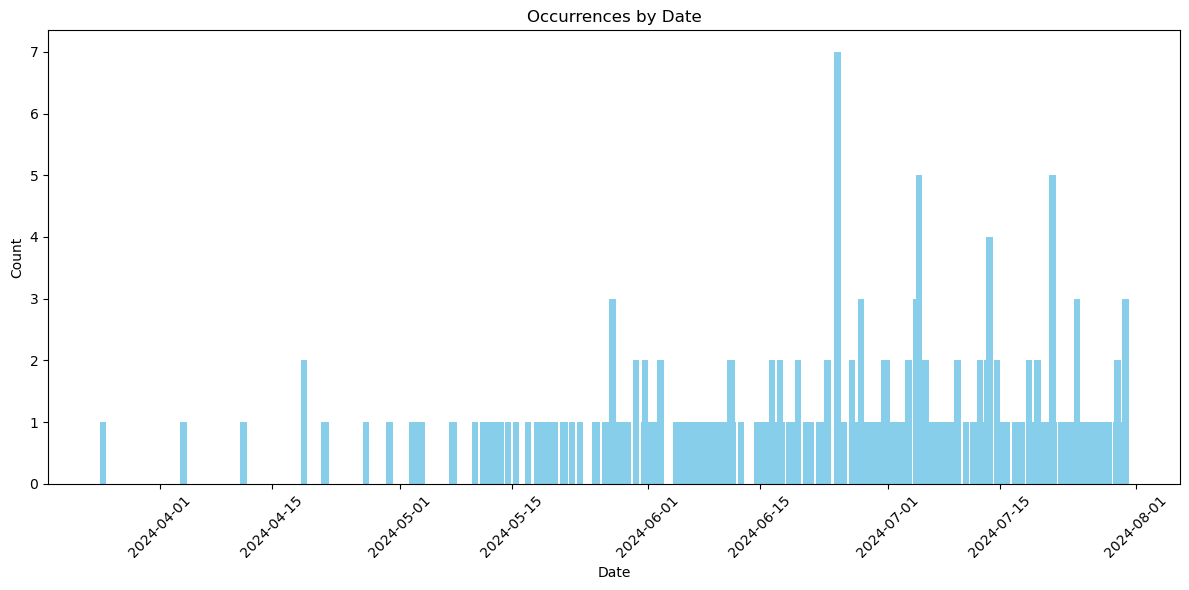

In [41]:
ngfs_irwin['ngfs_goes_timestamp'] = pd.to_datetime(ngfs_irwin['ngfs_goes_timestamp'])

# Count occurrences by date
counts = ngfs_irwin['ngfs_goes_timestamp'].value_counts().sort_index()

# Convert to DataFrame for easier plotting
counts_df = counts.reset_index()
counts_df.columns = ['Date', 'Count']

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(counts_df['Date'], counts_df['Count'], color='skyblue')

plt.title('Occurrences by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Visualization

Graphs all the alerts by day, with an hourly time slider included

In [31]:
# Define initial map settings
current_center = [36.7783, -119.4179]  # Approximate center of California
current_zoom = 6  # Initial zoom level


# Function to add a legend to the map
def add_legend(m):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 200px; 
                border:2px solid grey; background-color: white; z-index:9999; font-size:14px; 
                ">&nbsp; <b>Alert Types</b><br>
                &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; NGFS<br>
                &nbsp; <i class="fa fa-circle" style="color:purple"></i>&nbsp; GOES<br>
                &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; IRWIN<br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; PulsePoint<br>
                &nbsp; <i class="fa fa-circle" style="color:orange"></i>&nbsp; Intterra FIRIS<br>
                &nbsp; <i class="fa fa-circle" style="color:grey"></i>&nbsp; Manual Entry<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

# Function to update the map with new markers
def update_map_with_time(date, hour):
    global current_center, current_zoom

    # Recreate the map with the current center and zoom level
    m = folium.Map(location=current_center, zoom_start=current_zoom)
    
    # Add legend to the map
    add_legend(m)
    
    # Convert hour slider value to a time object
    selected_time = pd.Timestamp(f"1900-01-01 {hour}:00").time()

    # Filter data by the selected date
    filtered_df = combined_df[combined_df['date'] == date]

    # Further filter data by the selected hour (from 00:00 to selected hour)
    filtered_df = filtered_df[filtered_df['timestamp'].dt.time <= selected_time]

    # Add markers and buffers for each alert
    for _, row in filtered_df.iterrows():
        color = {
            'NGFS': 'blue',
            'GOES': 'purple',
            'IRWIN': 'green',
            'PulsePoint': 'red',
            'Intterra FIRIS': 'orange',
            'Manual Entry': 'grey'
        }.get(row['type'], 'black')  # Default color if type is not in the dictionary
        
        # Add buffer circle only for NGFS and GOES
        if row['type'] in ['NGFS', 'GOES']:
            folium.Circle(
                location=[row['lat'], row['lon']],
                radius=10_000,  # 10 km buffer
                color=color,
                fill=True,
                fill_opacity=0.2,
                weight=1,  # Ensure border is visible
                opacity=1  # Ensure circle is fully opaque
            ).add_to(m)
        
        # Add alert marker
        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=f"Type: {row['type']}<br>Date: {row['date']}<br>Time: {row['time']}",
            icon=folium.Icon(color=color)
        ).add_to(m)

    # Display the map
    clear_output(wait=True)
    display(m)

# Create widgets for date and hour
date_picker = widgets.DatePicker(
    value=pd.Timestamp('2023-09-04').date(),
    description='Date:'
)

hour_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=23,
    step=0.5,
    description='Hour:',
    continuous_update=True  # Ensure map updates dynamically
)

# Display widgets
widgets.interactive(update_map_with_time, date=date_picker, hour=hour_slider)

interactive(children=(DatePicker(value=datetime.date(2023, 9, 4), description='Date:'), FloatSlider(value=0.0,…

Only graphs alerts the NGFS and GOES alerts that have another alert within 10 km and 3 hour time window, by the day

In [30]:
# Define initial map settings
current_center = [36.7783, -119.4179]  # Approximate center of California
current_zoom = 6  # Initial zoom level

# Function to add a legend to the map
def add_legend(m):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 200px; 
                border:2px solid grey; background-color: white; z-index:9999; font-size:14px; 
                ">&nbsp; <b>Alert Types</b><br>
                &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; NGFS<br>
                &nbsp; <i class="fa fa-circle" style="color:purple"></i>&nbsp; GOES<br>
                &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; IRWIN<br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; PulsePoint<br>
                &nbsp; <i class="fa fa-circle" style="color:orange"></i>&nbsp; Intterra FIRIS<br>
                &nbsp; <i class="fa fa-circle" style="color:grey"></i>&nbsp; Manual Entry<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

# Function to check if two points are within a given distance
def is_within_distance(lat1, lon1, lat2, lon2, distance_km):
    return geodesic((lat1, lon1), (lat2, lon2)).km <= distance_km

# Function to update the map with new markers
def update_map_with_date(date):
    global current_center, current_zoom

    # Recreate the map with the current center and zoom level
    m = folium.Map(location=current_center, zoom_start=current_zoom)
    
    # Add legend to the map
    add_legend(m)
    
    # Filter data by the selected date
    filtered_df = combined_df[combined_df['date'] == date]

    # Get NGFS and GOES alerts
    ngfs_goes_alerts = filtered_df[filtered_df['type'].isin(['NGFS', 'GOES'])]
    
    # Initialize sets to keep track of alerts
    ngfs_goes_ids = set(ngfs_goes_alerts.index)
    valid_alerts = []
    
    # Check each NGFS/GOES alert if it has a related alert
    for _, ngfs_goes_row in ngfs_goes_alerts.iterrows():
        ngfs_goes_time = ngfs_goes_row['timestamp']
        has_related_alert = False
        for _, row in filtered_df.iterrows():
            if row.name in ngfs_goes_ids:
                continue  # Skip if the alert is NGFS or GOES
            time_diff = abs((ngfs_goes_time - row['timestamp']).total_seconds() / 3600)  # Time difference in hours
            if time_diff <= 3 and is_within_distance(ngfs_goes_row['lat'], ngfs_goes_row['lon'], row['lat'], row['lon'], 10):
                has_related_alert = True
                valid_alerts.append(row)
        if has_related_alert:
            valid_alerts.append(ngfs_goes_row)

    # Convert valid_alerts to DataFrame
    valid_alerts_df = pd.DataFrame(valid_alerts)

    # Add markers and buffers for each alert
    for _, row in valid_alerts_df.iterrows():
        color = {
            'NGFS': 'blue',
            'GOES': 'purple',
            'IRWIN': 'green',
            'PulsePoint': 'red',
            'Intterra FIRIS': 'orange',
            'Manual Entry': 'grey'
        }.get(row['type'], 'black')  # Default color if type is not in the dictionary
        
        # Add buffer circle only for NGFS and GOES
        if row['type'] in ['NGFS', 'GOES']:
            folium.Circle(
                location=[row['lat'], row['lon']],
                radius=10_000,  # 10 km buffer
                color=color,
                fill=True,
                fill_opacity=0.2,
                weight=1,  # Ensure border is visible
                opacity=1  # Ensure circle is fully opaque
            ).add_to(m)
        
        # Add alert marker
        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=f"Type: {row['type']}<br>Date: {row['date']}<br>Time: {row['time']}",
            icon=folium.Icon(color=color)
        ).add_to(m)

    # Display the map
    clear_output(wait=True)
    display(m)

# Create a widget for date
date_picker = widgets.DatePicker(
    value=pd.Timestamp('2023-09-04').date(),
    description='Date:'
)

# Display the date picker widget
widgets.interactive(update_map_with_date, date=date_picker)

interactive(children=(DatePicker(value=datetime.date(2023, 9, 4), description='Date:'), Output()), _dom_classe…